# The dataset

The work of Keisler 2022 is build upon the ERA5 (Hersbach et al. 2020) reanalysis dataset which contains a set of hourly 3D snapshot of the surface and atmosphere from 1950 to present.

An ERA5 version (interpolated to an 1&deg; x 1&deg; lat-lon grid and 37 vertical levels) identical to the dataset used in Keisler 2022 is available in cloud-storage hosted by Google's [Weatherbench2 project](https://weatherbench2.readthedocs.io/en/latest/data-guide.html) and can be found here:  

`gs://weatherbench2/datasets/era5/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr`  

Let's take a look at what is inside this dataset:

In [ ]:
import xarray as xr

ds = xr.open_zarr("gs://weatherbench2/datasets/era5/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr")
ds

<xarray.Dataset> Size: 34TB
Dimensions:                                           (time: 552264,
                                                       longitude: 360,
                                                       latitude: 181, level: 37)
Coordinates:
  * time                                              (time) datetime64[ns] 4MB ...
  * longitude                                         (longitude) float64 3kB ...
  * latitude                                          (latitude) float64 1kB ...
  * level                                             (level) int64 296B 1 .....
Data variables: (12/31)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 144GB dask.array<chunksize=(8, 360, 181), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 144GB dask.array<chunksize=(8, 360, 181), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 144GB dask.array<chunksize=(8, 360, 181), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 261kB dask.array<chunksize=(360, 181), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 261kB dask.array<chunksize=(360, 181), meta=np.ndarray>
    geopotential                                      (time, level, longitude, latitude) float32 5TB dask.array<chunksize=(8, 37, 360, 181), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, longitude, latitude) float32 144GB dask.array<chunksize=(8, 360, 181), meta=np.ndarray>
    type_of_high_vegetation                           (longitude, latitude) float32 261kB dask.array<chunksize=(360, 181), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 261kB dask.array<chunksize=(360, 181), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 5TB dask.array<chunksize=(8, 37, 360, 181), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 5TB dask.array<chunksize=(8, 37, 360, 181), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 5TB dask.array<chunksize=(8, 37, 360, 181), meta=np.ndarray>

The dataset contains 3D atmospheric fields. These fields are 4 dimensional, with dimensions:
 - `time`
 - `level` 
 - `longitude`
 - `latitude`
 

In [2]:
atmospheric_dims = ("time", "level", "longitude", "latitude")
atmospheric_fields = [var for var in ds.data_vars if ds[var].dims == atmospheric_dims]
print("3D atmospheric variables present in the dataset:")
for var in atmospheric_fields:
    print(f" - {var}")

3D atmospheric variables present in the dataset:
 - geopotential
 - specific_humidity
 - temperature
 - u_component_of_wind
 - v_component_of_wind
 - vertical_velocity


The dataset also contains some 2D surface variables. Thes fields are 3 dimensional with dimensions:
 - `time`
 - `longitude`
 - `latitude`

In [3]:
surface_dims = ("time", "longitude", "latitude")
surface_fields = [var for var in ds.data_vars if ds[var].dims == surface_dims]
print("2D surface variables present in the dataset:")
for var in surface_fields:
    print(f" - {var}")

2D surface variables present in the dataset:
 - 10m_u_component_of_wind
 - 10m_v_component_of_wind
 - 2m_temperature
 - mean_sea_level_pressure
 - sea_ice_cover
 - sea_surface_temperature
 - surface_pressure
 - toa_incident_solar_radiation
 - total_cloud_cover
 - total_column_water_vapour
 - total_precipitation


Finally, the dataset also contains some 2D constant (surface) fields.
These fields do not vary in time and hence are only 2 dimensional:
 - `longitude`
 - `latitude`

In [4]:
constant_dims = ("longitude", "latitude")
constant_fields = [var for var in ds.data_vars if ds[var].dims == constant_dims]
print("2D constant variables present in the dataset:")
for var in constant_fields:
    print(f" - {var}")

2D constant variables present in the dataset:
 - angle_of_sub_gridscale_orography
 - anisotropy_of_sub_gridscale_orography
 - geopotential_at_surface
 - high_vegetation_cover
 - lake_cover
 - lake_depth
 - land_sea_mask
 - low_vegetation_cover
 - slope_of_sub_gridscale_orography
 - soil_type
 - standard_deviation_of_filtered_subgrid_orography
 - standard_deviation_of_orography
 - type_of_high_vegetation
 - type_of_low_vegetation


The above dataset is [chunked](https://xarray.pydata.org/en/v0.10.2/dask.html) per variable (i.e. `xarray.DataArray`) and each `xarray.DataArray` is subsequently chunked in the following manner:

In [5]:
chunk_summary = {dim: chunks[0] for dim, chunks in zip(ds["geopotential"].dims, ds["geopotential"].chunks)}
for dim, size in chunk_summary.items():
    print(f"dimension {dim} has chunksize: {size}")

dimension time has chunksize: 8
dimension level has chunksize: 37
dimension longitude has chunksize: 360
dimension latitude has chunksize: 181


# anemoi-datasets

When doing Machine Learning model training, one typically uses (and needs to load) all variables at one specific date(-time).  
This means that the chunking pattern in the above dataset is not optimized for the data-access pattern during the training of an ML-model.
A more efficient approach would be to chunk the data by datetime, with each chunk containing all variables and grid points for that specific time.

Enter `anemoi-datasets`, a [package](https://anemoi.readthedocs.io/projects/datasets/en/latest/index.html) providing a structured approach to preparing datasets for data-driven weather forecasting models, particularly those using deep learning. By optimising data access patterns, anemoi-datasets minimises I/O operations, improving efficiency when training machine learning models.



In [6]:
import yaml
import os

## Create an anemoi-dataset

anemoi-datasets offers a simple high-level interface based on a YAML recipe file, which defines how datasets are processed and structured. The package allows you to:

 - Load and transform datasets from sources such as reanalyses or forecasts.

 - Interpolate data to a desired spatial resolution and temporal frequency to match model requirements.

 - Select and preprocess relevant meteorological variables for use in machine learning workflows.

 - Structure datasets for efficient access in training and inference, reducing unnecessary data operations.

The dataset definition is specified in a YAML file, which is then used to generate the dataset using the command-line tool `create` command.
For example:
```bash
anemoi-datasets create config.yaml name-of-output-dataset.zarr
```

## The `YAML` recipe file
The recipe files exists out of 4 main components and is organized as a python dictionary:  
1. **General description** (dictionary keys: `name`, `description`, `attribution` and `licence`)  
   These keys define the dataset name, a brief description, the attribution to the data source, and the licence under which the dataset is released. This information will be stored in the dataset metadata.  
     
2. **Temporal description** (dictionary key: `dates`) 
   Here, the time dimension of the anemoi dataset is defined. In particular, the start and end dates of the dataset and the *frequency* of the time steps.  
     
3. **Input description** (dictionary key: `input`) 
   This key specifies the input data that will be used. It specifies not only the data-type of original data but it also allows to select certain variables 
   and vertical levels. Here, also more complex operations like pre-proccessing actions can be defined.  
     
4. **Build description** (dictionary key: `build`) 
   Here, the specific options for building are defined.

The recipe is structured as a *dict-of-dicts* meaning that every key in the dictionary generally takes another dict as value (except for the general description keys).

We discuss each component in detail below.

In [7]:
# Config skeleton
recipe_keys = [
    "name",
    "description",
    "attribution",
    "licence",
    "dates",
    "input",
    "build"
]
recipe = dict.fromkeys(recipe_keys)
recipe

{'name': None,
 'description': None,
 'attribution': None,
 'licence': None,
 'dates': None,
 'input': None,
 'build': None}

### 1. General information
anemoi-datasets uses following [naming convection](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/naming-conventions.html):  
`purpose-content-source-resolution-start-year-end-year-frequency-version[-extra-str]`

In this case, the general information keys can thus be filled in as follows:

In [8]:
recipe["name"] = "keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0"
recipe["description"] = "Dataset as used in the Keisler 2022 pre-print"
recipe["attribution"] = "TBD"
recipe["licence"] = "TBD"

### 2. Temporal information
While the original dataset contains data at hourly intervals, only 3-hourly data is used in Keisler 2022.
For the sake of simplicity, a dataset containing only one day worth of data will be build here.
Both choices (data-frequency and time-period) are reflected in the name defined above.

As mentioned before, specifications per key are in turn defined by dictionaries. 


In [9]:
# Set the dates part of the config
dates = {
    "start": "1979-01-01T00:00:00",
    "end": "1979-01-02T00:00:00",
    "frequency": "3h",
}

# and add it to the config
recipe["dates"] = dates

### 3. The input variables
Different sources of input (e.g. netCDF-files and GRIB-files) can be combined to create an anemoi-dataset.  
Each source is defined as a dictionary where the key defines the source-type of the input ([see docs](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/sources.html)) and the value is a dictionary with settings specific to the source.

In this specific case only `zarr` files are used, hence the [`xarray-zarr`] type (https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/sources/xarray-zarr.html) is used.

Let's define the dictionary for the upper-air variables first:

In [10]:
# Some general info about the source for easier re-use
url = "gs://weatherbench2/datasets/era5/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr"
zarr_options = {"storage_options" : {"token": "anon"}}
pressure_levels = [50, 100, 150, 200, 250, 300,400, 500, 600, 700, 850, 925, 1000]

# Dictionary configuring the upper-air variables
upper_air_variables = {
    "xarray-zarr": {                    # The key defining the type, the value is another dictionary with options
        "url": url,                     # The URL of the dataset
        "param": atmospheric_fields,    # The variables to extract                   
        "level": pressure_levels,       # The verical (pressure) levels
        "options": zarr_options,        # Some zarr-specific keyword arguments
    }
}

As mentioned before, certain variables are constant throughout the original dataset.  
For ML-training, however,  it is easier to add these constant fields along the temporal dimension for easy loading during training.  
For this, we can use the [repeated-dates input-type](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/sources/repeated-dates.html). 
In Keisler 2022, two ERA5 specific constant fields are used:
 - Land Sea Mask, indication if a gridpoint is land or sea,
 - Surface Geopotential which is equivalent with the height of the surface above sea level.

In [11]:
constant_variables = { 
    "repeated-dates": {      # The key defining the type.
        "mode": "constant",  # The mode, defining here that the fields are constant, other options (climatology, closest) exist
        "source": {          # Which source to use for the constant fields
            "xarray-zarr": { # An xarray-zarr source as defined above
                "url": url,
                "param": ["geopotential_at_surface", "land_sea_mask"],
                "options": zarr_options,
            }
        }
    }
}

Typically, ML weather prediction models also use input-variables that are not dataset-specific, but rather give the model information  
about the time of the year or day or about the location of grid point on the globe.
This type of variables are called [forcings](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/sources/forcings.html) in anemoi-datasets and can be directly derived during the building of the dataset.
The only thing you need to provide is a *template*: another source in the dataset from which anemoi-datasets can derive grid-information.  
The template value typically is a *path* to another source in the recipe.

In [12]:
forcings = {
    "forcings": {
        "template": "${input.join.1.xarray-zarr}", # Path to another source in the recipe dictionary.
        "param": [
            "cos_latitude",
            "cos_longitude",
            "sin_latitude",
            "sin_longitude",
            "julian_day",
            "insolation",
        ]
    }
}

Finally, anemoi-datasets needs to know how to [combine](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/building/operations.html) these different data sources.
Since, the source contain different variables for the same period, we can `join` them.
Other options exist:
 - concat: concatenate along the temporal dimension
 - pipe: feed the data forward to another operation

In [13]:
# We can combine all these datasets by joining them using the join key in a dictionary
recipe["input"] = {
    "join": [
        constant_variables,
        upper_air_variables,
        forcings
    ]
}

### 4. Build options
Settings controlling the building of the anemoi-dataset are set in the `build` part of the config. Some basic keys are:
- `group_by`: controls the amount of date-times to be processed simultaneously, reduce this if you are getting out-of-memory issues. Values can be integers or keywords indicating a certain period: `daily`, `weekly`, `monthly`.
- `variable_naming`: what metadata key will be used to name the variables, make sure that the metadata key is unique for every variable, e.g. the metadata key `param_levelist` combines the parameter name (`t`, `u`, ...) with the vertical level.




In [14]:
build = {
    "group_by": "daily", 
    "variable_naming": "param_levelist",
}

recipe["build"] = build

### 5. Final result
Lets inspect the final recipe dictionary and save the dictionary as a yaml_file. Then, the dataset can be created using the `anemoi-dataset create` command.

In [15]:
print(
    yaml.dump(
        recipe,
        default_flow_style=False
    )
)

attribution: TBD
build:
  group_by: daily
  variable_naming: param_levelist
dates:
  end: '1979-01-02T00:00:00'
  frequency: 3h
  start: '1979-01-01T00:00:00'
description: Dataset as used in the Keisler 2022 pre-print
input:
  join:
  - repeated-dates:
      mode: constant
      source:
        xarray-zarr:
          options: &id001
            storage_options:
              token: anon
          param:
          - geopotential_at_surface
          - land_sea_mask
          url: gs://weatherbench2/datasets/era5/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr
  - xarray-zarr:
      level:
      - 50
      - 100
      - 150
      - 200
      - 250
      - 300
      - 400
      - 500
      - 600
      - 700
      - 850
      - 925
      - 1000
      options: *id001
      param:
      - geopotential
      - specific_humidity
      - temperature
      - u_component_of_wind
      - v_component_of_wind
      - vertical_velocity
      url: gs://weatherbench2/datasets/era5/1959-20

In [20]:
from pathlib import Path

ROOT_DIR = Path.cwd().parent

name = recipe["name"]
recipe_dir = ROOT_DIR / "configs/datasets"
recipe_dir.mkdir(parents=True, exist_ok=True)
recipe_path = recipe_dir / f"{name}.yaml"
with open(recipe_path, 'w') as file:
    yaml.dump(recipe, file, default_flow_style=False)

dataset_dir = ROOT_DIR / "output/datasets"
dataset_dir.mkdir(parents=True, exist_ok=True)
dataset_path = dataset_dir / f"{name}.zarr"

Note: we will create the dataset with a `--test` flag, so it will only consider the first four timesteps.

In [21]:
!anemoi-datasets create --overwrite {recipe_path} {dataset_path} --test

2025-10-23 18:04:24 INFO 🎬 Task init((),{}) starting
2025-10-23 18:04:26 INFO Setting flatten_grid=True in config
2025-10-23 18:04:26 INFO Setting ensemble_dimension=2 in config
2025-10-23 18:04:26 INFO Setting flatten_grid=True in config
2025-10-23 18:04:26 INFO Setting ensemble_dimension=2 in config
2025-10-23 18:04:26 INFO {'end': '1979-01-02T00:00:00', 'frequency': '3h', 'start': '1979-01-01T00:00:00', 'group_by': 'daily'}
2025-10-23 18:04:26 INFO Groups(dates=2,StartEndDates(1979-01-01 00:00:00..1979-01-02 00:00:00 every 3:00:00))
2025-10-23 18:04:26 INFO Groups: Groups(dates=2,StartEndDates(1979-01-01 00:00:00..1979-01-02 00:00:00 every 3:00:00))
2025-10-23 18:04:32 INFO Minimal input for 'init' step (using only the first date) : GroupOfDates(dates=['1979-01-01T00:00:00'])
2025-10-23 18:04:32 INFO JoinResult: 1 dates (1979-01-01T00:00)
  JoinResult: 1 dates (1979-01-01T00:00)
    DateMapperResult: 0 dates ()
      
  xarray-zarr(GroupOfDates(dates=['1979-01-01T00:00:00']))
  forc

Once created, you can get a quick overview of what is inside the anemoi-dataset using the `inspect` command.

In [22]:
!anemoi-datasets inspect {dataset_path}

📦 Path          : /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr
🔢 Format version: 0.30.0

📅 Start      : 1979-01-01 00:00
📅 End        : 1979-01-02 00:00
⏰ Frequency  : 3h
🚫 Missing    : 0
🌎 Resolution : None
🌎 Field shape: [360, 181]

📐 Shape      : 9 × 86 × 1 × 65,160 (192.4 MiB)
💽 Size       : 139.6 MiB (139.6 MiB)
📁 Files      : 48

   Index │ Variable                 │         Min │         Max │         Mean │       Stdev
   ──────┼──────────────────────────┼─────────────┼─────────────┼──────────────┼────────────
       0 │ cos_latitude             │ 6.12323e-17 │           1 │     0.633086 │    0.310546
       1 │ cos_longitude            │          -1 │           1 │            0 │    0.707107
       2 │ geopotential_100         │      144096 │      163438 │       157625 │      4665.3
       3 │ geopotential_1000        │    -3984.47 │     4099.62 │      798.481 │     979.562
       4 │ geopotentia

`anemoi-dataset` offers an API to interact with the dataset. The main entry point is the [`open_dataset`](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/using/opening.html) function:

In [23]:
from anemoi.datasets import open_dataset
ds_anemoi = open_dataset(dataset_path)
print(ds_anemoi)

/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr


That doesn't tell us much. We can interact with the dataset through its various [methods and attributes](https://anemoi.readthedocs.io/projects/datasets/en/latest/datasets/using/methods.html)

In [24]:
print(f"The anemoi-datasets {ds_anemoi} has a shape: {ds_anemoi.shape} and contains:")
print(f" - {len(ds_anemoi)} dates: ")
for date in ds_anemoi.dates:
    print(f"    - {date} at index {ds_anemoi.dates_interval_to_indices(start=date,end=date)}")
print(f" - {len(ds_anemoi.variables)} variables:")
print(f"    - the first 10 are: {', '.join(ds_anemoi.variables[:10])}")
print(f" - {ds_anemoi.grids[0]} gridpoints, originating from a {ds_anemoi.field_shape} grid")

The anemoi-datasets /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr has a shape: (9, 86, 1, 65160) and contains:
 - 9 dates: 
    - 1979-01-01T00:00:00 at index [0]
    - 1979-01-01T03:00:00 at index [1]
    - 1979-01-01T06:00:00 at index [2]
    - 1979-01-01T09:00:00 at index [3]
    - 1979-01-01T12:00:00 at index [4]
    - 1979-01-01T15:00:00 at index [5]
    - 1979-01-01T18:00:00 at index [6]
    - 1979-01-01T21:00:00 at index [7]
    - 1979-01-02T00:00:00 at index [8]
 - 86 variables:
    - the first 10 are: cos_latitude, cos_longitude, geopotential_100, geopotential_1000, geopotential_150, geopotential_200, geopotential_250, geopotential_300, geopotential_400, geopotential_50
 - 65160 gridpoints, originating from a (360, 181) grid


The data can be visualized in two ways.
1. Manually:

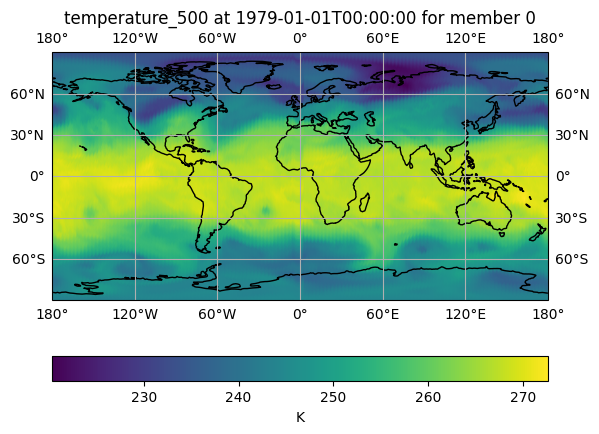

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
variable = "temperature_500"
date = "1979-01-01T00:00:00"
member = 0
values = ds_anemoi[
    ds_anemoi.dates_interval_to_indices(
        start=date,
        end=date
    )[0],
    ds_anemoi.name_to_index[variable],
    member,
    :
]

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.scatter(
    ds_anemoi.longitudes,
    ds_anemoi.latitudes,
    c=values,
)
ax.set_title(f"{variable} at {date} for member {member}")
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.colorbar(im, label="K", orientation="horizontal")



2. Using the built-in plotting method:

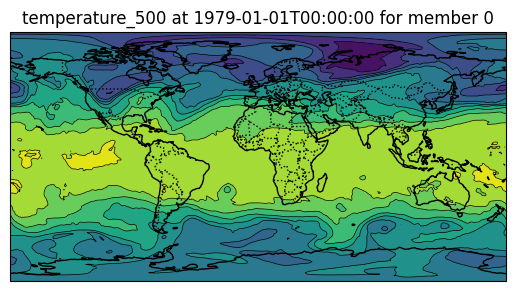

In [26]:
ax = ds_anemoi.plot(variable=variable, date=date, member=member,title=f"{variable} at {date} for member {member}")


An anemoi-dataset not only contains the field data, it also stores the statistics so that they don't need to be recomputed for normalization during training.

In [27]:
print(f"The statistics of variable {variable} are:")
for stat in ds_anemoi.statistics.keys():
    print(f" - {stat}: {ds_anemoi.statistics[stat][ds_anemoi.name_to_index[variable]]}")


The statistics of variable temperature_500 are:
 - mean: 252.2760479698325
 - stdev: 12.68784166983773
 - maximum: 272.9187316894531
 - minimum: 219.61648559570312


Finally, let’s look at how the anemoi-datasets package structures the data. For this we open the dataset using `xarray`'s zarr engine:

In [28]:
ds2 = xr.open_zarr(dataset_path, consolidated=False)
ds2

<xarray.Dataset> Size: 203MB
Dimensions:     (variable: 86, time: 9, ensemble: 1, cell: 65160)
Dimensions without coordinates: variable, time, ensemble, cell
Data variables:
    count       (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    data        (time, variable, ensemble, cell) float32 202MB dask.array<chunksize=(1, 86, 1, 65160), meta=np.ndarray>
    dates       (time) datetime64[s] 72B dask.array<chunksize=(9,), meta=np.ndarray>
    has_nans    (variable) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    latitudes   (cell) float64 521kB dask.array<chunksize=(32580,), meta=np.ndarray>
    longitudes  (cell) float64 521kB dask.array<chunksize=(32580,), meta=np.ndarray>
    maximum     (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    mean        (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    minimum     (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    squares     (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    stdev       (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    sums        (variable) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
Attributes: (12/30)
    allow_nans:              False
    attribution:             TBD
    constant_fields:         ['cos_latitude', 'cos_longitude', 'geopotential_...
    data_request:            {'area': None, 'grid': None, 'param_level': {}, ...
    description:             Dataset as used in the Keisler 2022 pre-print
    end_date:                1979-01-02T00:00:00
    ...                      ...
    total_size:              146353425
    uuid:                    5ffb146f-5dcc-4cce-a871-cbf79828dc62
    variables:               ['cos_latitude', 'cos_longitude', 'geopotential_...
    variables_metadata:      {'cos_latitude': {'computed_forcing': True, 'con...
    variables_with_nans:     []
    version:                 0.30

The `xr.Dataset` now no longer contains `xr.DataArray`s for all different variables but instead the variables all sit in one `xr.DataArray`.

In [29]:
ds2["data"]

<xarray.DataArray 'data' (time: 9, variable: 86, ensemble: 1, cell: 65160)> Size: 202MB
dask.array<open_dataset-data, shape=(9, 86, 1, 65160), dtype=float32, chunksize=(1, 86, 1, 65160), chunktype=numpy.ndarray>
Dimensions without coordinates: time, variable, ensemble, cell

As seen above, one chunk of data now contains one datetime and all variables and gridpoints. This means that during training one sample (i.e one datetime) can be efficiently loaded by the dataloader.